# This installs the necessary libraries.
**tensorflow:** This is an open-source deep learning framework used to build and train neural networks.

**opencv-python:** It will help capture and process video frames from a webcam or camera, detect objects, and perform image manipulations.

**mediapipe:** It is useful for hand tracking and landmark detection, making it ideal for gesture recognition tasks.

**scikit-learn:** A machine learning library for Python, used for data preprocessing, model evaluation.

In [ ]:
!pip install tensorflow opencv-python mediapipe scikit-learn
!pip install --upgrade protobuf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour 

# imports essential libraries and modules for your hand gesture recognition project:
**mediapipe as mp**: MediaPipe is used for detecting and tracking hand landmarks, making it a crucial component for recognizing hand gestures.

**tensorflow as tf**: TensorFlow is a deep learning library used to create, train, and deploy neural networks for classifying hand gestures.

In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Initializes MediaPipe to track hand landmarks and includes functions to:

**Preprocess the image**(blur it to reduce noise for better accuracy).
Segment the hand by converting the image to grayscale and highlighting the hand region.

**Extract hand landmarks** (21 key points) from an image, which are essential for identifying hand gestures.


These steps clean up the image and gather important hand data for gesture recognition.

In [ ]:
# Initialize Mediapipe Hand
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()

# Preprocessing Functions
def preprocess_image(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def segment_hand(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

def extract_hand_landmarks(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image)
    num_landmarks = 21 * 3
    landmarks = np.zeros(num_landmarks)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            for i, lm in enumerate(hand_landmarks.landmark):
                if i < 21:
                    landmarks[i * 3] = lm.x
                    landmarks[i * 3 + 1] = lm.y
                    landmarks[i * 3 + 2] = lm.z

    # Check if landmarks are valid
    if np.any(np.isnan(landmarks)):
        print(f"NaN values found in landmarks for image: {image_path}")

    return landmarks


# Mounting google drive for accessing files.

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prepares the dataset for hand gesture recognition:

**prepare_data function:** Loads images from the specified directory, extracts hand landmarks, and assigns class labels.

**Training and Test Data:** Loads training and test datasets from specified directories.

**Normalization:** Scales the data to a range of 0 to 1 for improved model performance.

**Class Weights:** Computes class weights to address any class imbalance in the dataset.

**Output:** Prints the shapes of the training and test data arrays.

Overall, it organizes and processes the data for effective training of the gesture recognition model.

In [ ]:
def prepare_data(dataset_dir):
    data = []
    labels = []
    class_names = os.listdir(dataset_dir)
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(dataset_dir, class_name)
        for image_file in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_file)
            landmarks = extract_hand_landmarks(image_path)
            data.append(landmarks)
            labels.append(label)
    return np.array(data), np.array(labels)


train_data_dir = '/content/drive/MyDrive/SASP/Dataset/train'
test_data_dir = '/content/drive/MyDrive/SASP/Dataset/test'

train_data, train_labels = prepare_data(train_data_dir)
test_data, test_labels = prepare_data(test_data_dir)

# Normalize
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

# Calculate class weights to deal with class imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))

print("Training Data Shape:", train_data.shape)
print("Training Labels Shape:", train_labels.shape)
print("Test Data Shape:", test_data.shape)
print("Test Labels Shape:", test_labels.shape)


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Training Data Shape: (400, 63)
Training Labels Shape: (400,)
Test Data Shape: (180, 63)
Test Labels Shape: (180,)


# Defines and trains a neural network model for hand gesture recognition:

**Model Structure:**A Sequential model with three Dense layers (ReLU activation), Batch Normalization, and Dropout to prevent overfitting. The output layer uses softmax for multi-class classification.

**Compilation:** The model is compiled with the Adam optimizer and sparse categorical crossentropy loss.

**Callbacks:** Implements EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau for efficient training.

**Training:** Trains on the training data for up to 200 epochs with a batch size of 32, using class weights for imbalanced data.

**Model Saving:** Saves the trained model in .h5 format.

This process creates and optimizes a neural network for accurate gesture recognition.

In [ ]:
# Model definition
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(train_data.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(len(np.unique(train_labels)), activation='softmax'))

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=150, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/SASP/Dataset/best_model.keras', save_best_only=True, save_weights_only=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model with validation, class weights, and callbacks
model.fit(train_data, train_labels, epochs=200, batch_size=32, validation_split=0.2, class_weight=class_weights_dict, callbacks=[early_stopping, model_checkpoint])

# Save the final model in .h5 format
model.save('/content/drive/MyDrive/SASP/Dataset/final_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.2886 - loss: 1.7065 - val_accuracy: 0.7750 - val_loss: 1.2755
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3882 - loss: 1.5196 - val_accuracy: 0.4625 - val_loss: 1.3122
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3972 - loss: 1.4085 - val_accuracy: 0.1750 - val_loss: 1.3781
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4254 - loss: 1.3291 - val_accuracy: 0.0000e+00 - val_loss: 1.4606
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5248 - loss: 1.1899 - val_accuracy: 0.0000e+00 - val_loss: 1.5410
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5631 - loss: 1.1188 - val_accuracy: 0.0000e+00 - val_loss: 1.6180
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5406 - loss: 1.0939 - val_accuracy: 0.0000e+00 - val_loss: 1.6860
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5504 - loss: 1.0170 - val_acc

# Evaluates the trained model on the test dataset:

**Make Predictions:** Uses the model to predict class probabilities for the test data and converts them to predicted labels.

**Class Names:** Retrieves class names for generating a report.

**Generate Classification Report:** Creates and prints a report showing precision, recall, and F1-score for each gesture class.

Overall, it assesses the model's performance on hand gesture recognition.








In [ ]:
# Make predictions on the test data
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

from google.colab import drive
drive.mount('/content/drive')

# Use the correct variable name for the dataset directory
class_names = os.listdir(test_data_dir)

# Generate a classification report
report = classification_report(test_labels, predicted_labels, target_names=class_names)
print(report)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
              precision    recall  f1-score   support

   thumps_up       1.00      1.00      1.00        45
 thumps_down       1.00      1.00      1.00        45
        stop       0.98      1.00      0.99        45
    iloveyou       1.00      0.98      0.99        45

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



# Displays a random image from the test dataset:

**Function show_random_image:** Selects a random class and image, loads it, and displays it with the class label.

**Function Call:** Calls the function to show a random test image.

Overall, it visualizes a random image from the dataset along with its class label.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


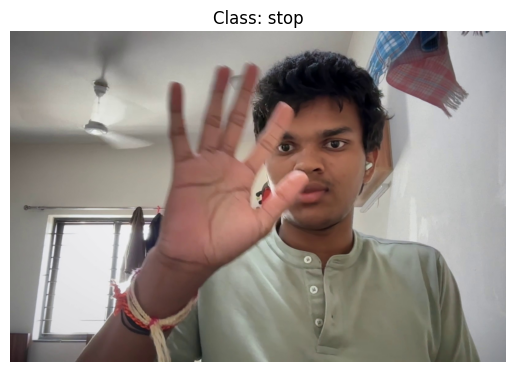

In [ ]:
from google.colab import drive # import the drive module for mounting

# Mount Google Drive
drive.mount('/content/drive')

def show_random_image(test_data_dir, class_names):
    # Get a random class name
    class_name = random.choice(class_names)
    class_folder = os.path.join(test_data_dir, class_name)

    # Get a random image from that class
    image_file = random.choice(os.listdir(class_folder))
    image_path = os.path.join(class_folder, image_file)

    # Load and display the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.title(f"Class: {class_name}")
    plt.axis('off')
    plt.show()

# Define test_data_dir and class_names before calling the function
test_data_dir = '/content/drive/MyDrive/SASP/Dataset/test' # Define test_data_dir
class_names = os.listdir(test_data_dir) # Define class_names using os.listdir

# Call the function

show_random_image(test_data_dir, class_names)


# Random Image Prediction
- **Model Loading**: Loads a pre-trained gesture recognition model.
- **MediaPipe Initialization**: Sets up MediaPipe's hand landmark detection with specific parameters.
- **Image Upload and Processing**:
  - Prompts user to upload an image.
  - Reads and converts the image to RGB format.
  - Detects hand landmarks and creates a 63-element feature vector if a hand is found.
- **Prediction**:
  - Uses the model to predict gesture based on landmark vector.
  - Displays predicted gesture label and confidence.
- **Display**: Shows the image with predicted label; shows a message if no hands are detected.

In [ ]:
# Random Image Prediction
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import mediapipe as mp

# Load your trained model
model_path = '/content/drive/MyDrive/SASP/Dataset/final_model.h5'  # Replace with your actual model path
model = load_model(model_path)

# Define class names (update as per your actual class names)
class_names = ['thumbs_up', 'thumbs_down', 'stop', 'iloveyou']  # Update class names accordingly

# Initialize MediaPipe Hands model
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)


def upload_and_classify_image():
    uploaded = files.upload()  # This will prompt the user to upload an image

    for image_name in uploaded.keys():
        img = cv2.imread(image_name)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        results = hands.process(img_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                landmark_vector = []
                for landmark in hand_landmarks.landmark:
                    landmark_vector.append(landmark.x)
                    landmark_vector.append(landmark.y)
                    landmark_vector.append(landmark.z)

                landmark_vector = np.array(landmark_vector).reshape(1, -1)  # Shape: (1, 63)

                # Make prediction
                predictions = model.predict(landmark_vector)
                predicted_class = np.argmax(predictions, axis=1)[0]
                predicted_label = class_names[predicted_class]
                confidence = predictions[0][predicted_class]

                # Display the image and predicted label
                plt.imshow(img_rgb)
                plt.title(f"Predicted Label: {predicted_label} (Confidence: {confidence:.2f})")
                plt.axis('off')  # Hide axes
                plt.show()
        else:
            print("No hand landmarks detected.")

# Call the function to upload and classify an image
upload_and_classify_image()

# Real time Implementation
Here's a summary of the **Real-Time Hand Gesture Recognition Code**:

- **Model Loading**:
  - Loads a pre-trained model using `load_model()`.
  - Update the model path (`r'C:\\Users\\your_username\\path_to_model\\final_model.h5'`) to match the location on your system.

- **MediaPipe Hand Landmark Detection**:
  - Initializes MediaPipe’s `Hands` model to detect hand landmarks in real-time.
  - Processes video frames to detect hand landmarks (21 key points).

- **Preprocessing Function**:
  - Converts frame to RGB.
  - Extracts hand landmarks and normalizes them.
  - Returns a feature vector of hand landmarks (63 values).

- **Prediction Function**:
  - Normalizes landmarks and reshapes them for model input.
  - Makes a prediction using the pre-trained model.
  - Outputs the predicted class and associated probabilities.

- **Real-Time Video Capture**:
  - Captures video from the webcam using OpenCV (`cv2.VideoCapture(0)`).
  - Displays the frame with predictions and labels.

- **User Interaction**:
  - Press '1', '2', '3', or '4' to manually label the gestures.
  - Press 'q' to quit the webcam feed.

- **Classification Report**:
  - After quitting, generates a classification report comparing true labels with predicted labels.
  - Displays precision, recall, F1-score, and accuracy for each class.

- **Metrics Calculation**:
  - Computes accuracy for each gesture class.
  - Generates a detailed evaluation table showing performance metrics.

### Key Points:
- **True Labeling**: Users can manually label gestures during real-time prediction (using '1', '2', '3', or '4').
- **Real-Time Evaluation**: Provides real-time gesture classification with feedback on the webcam stream.
- **Report Generation**: After the session, a classification report is created showing precision, recall, F1-score, and accuracy for each gesture class.

In [ ]:
# Real time Implementation
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import pandas as pd
import time

model = load_model(r'C:\\Users\\chall\\OneDrive\\Desktop\\Hand_Gesture_Recognition\\SASP\\Dataset\\final_model.h5', compile=False)

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)


class_names = ['thumbs_up', 'thumbs_down', 'stop', 'iloveyou']

def preprocess_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)
    if results.multi_hand_landmarks:
        landmarks = np.zeros(21 * 3)
        for hand_landmarks in results.multi_hand_landmarks:
            for i, lm in enumerate(hand_landmarks.landmark):
                landmarks[i * 3] = lm.x
                landmarks[i * 3 + 1] = lm.y
                landmarks[i * 3 + 2] = lm.z
        return landmarks
    return None

def predict_frame(landmarks):
    if landmarks is not None:
        landmarks = landmarks / np.max(landmarks)
        landmarks = np.expand_dims(landmarks, axis=0)
        prediction = model.predict(landmarks)
        predicted_label = np.argmax(prediction)
        return class_names[predicted_label], prediction[0]
    return None, None

cap = cv2.VideoCapture(0)

true_labels = []
predicted_labels = []

if not cap.isOpened():
    print("Error: Could not open webcam.")
else:
    print("Press 'q' to quit the webcam feed and '1', '2', '3', '4' to label the gestures.")

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            print("Error: Failed to capture image.")
            break

        landmarks = preprocess_frame(frame)
        prediction, probabilities = predict_frame(landmarks)

        if landmarks is not None and prediction:
            predicted_labels.append(prediction)

            cv2.putText(frame, f"Prediction: {prediction}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow("Real-Time Hand Gesture Recognition", frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif chr(key) in '1234':
            true_labels.append(class_names[int(chr(key)) - 1])

    cap.release()
    cv2.destroyAllWindows()


    if true_labels:
        report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
    else:
        true_labels = predicted_labels
        report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)

    df_report = pd.DataFrame(report).transpose()

    df_report = df_report[~df_report.index.isin(['accuracy', 'macro avg', 'weighted avg', 'support'])]

    df_report = df_report[['precision', 'recall', 'f1-score']]

    class_accuracies = []
    for class_name in class_names:
        correct_class_predictions = (np.array(predicted_labels) == np.array(true_labels))
        class_accuracy = (correct_class_predictions).mean()
        class_accuracies.append(class_accuracy)

    df_report['accuracy'] = class_accuracies

    print("\nEvaluation Metrics:")
    print(df_report)